In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style('ticks')

In [183]:
def preprocess_race():

    race_df = pd.read_csv('../input/big-data-derby-2022/nyra_race_table.csv')

    race_df['race_id'] = race_df[['track_id', 'race_date', 'race_number']].astype('str').agg('_'.join, axis = 1)
    race_df.insert(0, 'race_id', race_df.pop('race_id'))
    
    
    race_df['distance_feet'] = race_df['distance_id'].apply(lambda x : int(6.6 * x)) # to_feet
    
    race_df['race_date'] = pd.to_datetime(race_df['race_date'])
    
    race_df['track_condition'] = race_df['track_condition'].str.replace(" ", "")

    # Dirt Condition Separate 
    race_df.loc[race_df['course_type'] == 'D', 'dirt_condition'] = race_df['track_condition']
    dirt_condition_order = pd.CategoricalDtype(['FT', 'GD', 'MY', 'SY'], ordered = True)
    race_df['dirt_condition'] = race_df['dirt_condition'].astype(dirt_condition_order)
    
    # Turf Condition Separate
    race_df.loc[race_df['course_type'].isin(['I', 'O', 'T']), 'turf_condition'] = race_df['track_condition']
    turf_condition_order = pd.CategoricalDtype(['FM', 'GD', 'YL', 'SF'], ordered = True)
    race_df['turf_condition'] = race_df['turf_condition'].astype(turf_condition_order)
    
    race_df.drop(['purse', 'post_time', 'track_condition'], axis = 1, inplace = True)
    
    # drop hurdle race
    race_df.drop(race_df[race_df['course_type'] == 'M'].index, inplace = True)
    
    return race_df

def preprocess_start():
    start_df = pd.read_csv('../input/big-data-derby-2022/nyra_start_table.csv', 
                        names = ['track_id', 'race_date', 'race_number', 'program_number', 'weight_carried', 'jockey', 'odds', 'position_at_finish'])
    
    start_df['race_date'] = pd.to_datetime(start_df['race_date'])
    
    start_df['program_number'] = start_df['program_number'].str.replace(" ", "")
    return start_df

def preprocess_track():
    track_df = pd.read_csv('../input/big-data-derby-2022/nyra_tracking_table.csv')
    
    track_df['race_date'] = pd.to_datetime(track_df['race_date'])
    
    track_df['program_number'] = track_df['program_number'].str.replace(" ", "")

    return track_df

# 나중에 다른 파일에 전처리 과정을 또 넣을 수도 있기 때문에 위 과정은 함수로 따로 빼겠음
# 캐글에서만 사용 가능, 다른 곳에 쓸 경우 경로명 정도만 바꾸면 될 것임

def preprocess_2022_derby():
    race_df = preprocess_race()
    start_df = preprocess_start()
    track_df = preprocess_track()
    return race_df, start_df, track_df

race_df, start_df, track_df = preprocess_2022_derby()

# 2. 데이터 탐색
- 중구난방식으로 하기 보다, 무엇을 할지 적어 두고 어떤 작업을 진행하자

## 1. 계절과 트랙
- 트랙 컨디션 [위키](https://en.wikipedia.org/wiki/Going_(horse_racing))
    - `Dirt` 
        - `FT : Fast` : 건조하고 균일하며 탄력 있는 표면
        - `GD : Good` : `FT`보다는 느린 듯
        - `MY : Muddy` : 젖었음, 고인 물은 없음
        - `SY : Sloppy` : 고인 물이 보일 정도로 물로 포화된 트랙
    - `Turf`
        - `FM : Firm` : 단단하고 탄력 있는 표면
        - `GD : Good` : `FM`보다 약간 부드러운 잔디 코스
        - `YL : Yielding` : 최근 비가 와서 지면에 상당한 양의 `give(탄성)`가 있음
        - `SF : Soft` : 수분이 많음. 말이 깊게 가라앉을 수 있음


In [184]:
# 1. 계절과 트랙의 상태
race_df['month'] = race_df['race_date'].dt.month

race_df.loc[race_df['month'].isin([3, 4, 5]), 'season'] = 'spring'
race_df.loc[race_df['month'].isin([6, 7, 8]), 'season'] = 'summer'
race_df.loc[race_df['month'].isin([9, 10, 11]), 'season'] = 'autumn'
race_df.loc[race_df['month'].isin([12, 1, 2]), 'season'] = 'winter'

season_order = pd.CategoricalDtype(['spring', 'summer', 'autumn', 'winter'],
                                        ordered = True)
race_df['season'] = race_df['season'].astype(season_order)

race_df

,race_id,track_id,race_date,race_number,distance_id,course_type,run_up_distance,race_type,distance_feet,dirt_condition,turf_condition,month,season
0,AQU_2019-01-01_1,AQU,2019-01-01,1,650,D,36,AOC,4290,MY,NaN,1,winter
1,AQU_2019-01-01_2,AQU,2019-01-01,2,600,D,48,MCL,3960,MY,NaN,1,winter
2,AQU_2019-01-01_3,AQU,2019-01-01,3,550,D,54,MCL,3630,MY,NaN,1,winter
3,AQU_2019-01-01_4,AQU,2019-01-01,4,900,D,101,AOC,5940,MY,NaN,1,winter
4,AQU_2019-01-01_5,AQU,2019-01-01,5,700,D,60,ALW,4620,MY,NaN,1,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,SAR_2019-09-02_7,SAR,2019-09-02,7,900,D,79,CLM,5940,SY,NaN,9,autumn
1996,SAR_2019-09-02_8,SAR,2019-09-02,8,700,D,32,AOC,4620,SY,NaN,9,autumn
1997,SAR_2019-09-02_9,SAR,2019-09-02,9,850,I,22,STK,5610,NaN,SF,9,autumn
1998,SAR_2019-09-02_10,SAR,2019-09-02,10,700,D,32,STK,4620,SY,NaN,9,autumn


In [185]:
sub_dirt_df = (race_df.groupby(['season', 'dirt_condition'])['race_id'].count()
                                                                      .to_frame()
                                                                      .reset_index()
                                                                      .rename(columns = {"race_id" : 'counts'})
              )
sub_dirt_df = sub_dirt_df[sub_dirt_df['counts'] != 0]

sub_turf_df = (race_df.groupby(['season', 'turf_condition'])['race_id'].count()
                                                                       .to_frame()
                                                                       .reset_index()
                                                                       .rename(columns = {"race_id" : 'counts'})
              )
sub_turf_df = sub_turf_df[sub_turf_df['counts'] != 0]

- 색은 여기서 뽑아옴 : [color-hex.com](https://www.color-hex.com/)
- seaborn의 기능을 이용해도 되긴 함

In [186]:
dirt_colors = ['#783f04', '#bb8632', '#cca466', '#ddc299']
turf_colors = ['#38761d', '#5f914a', '#87ac77', '#afc8a4']

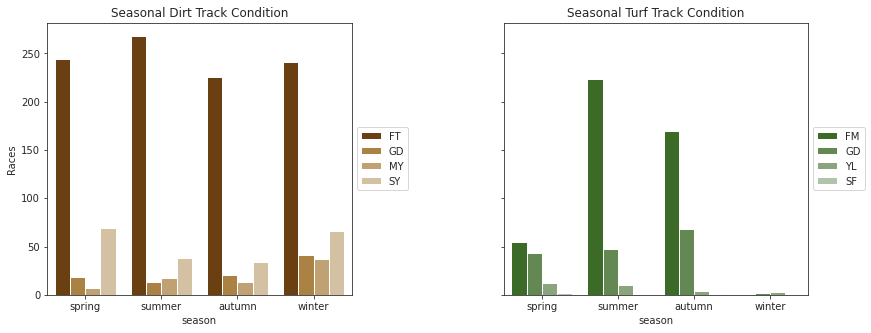

In [187]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)

dirt_palette = sns.set_palette(sns.color_palette(dirt_colors))
sns.barplot(data = sub_dirt_df,
              x = 'season',
              y = 'counts',
             hue = 'dirt_condition',
             ax = ax[0],
             palette = dirt_palette
           )
ax[0].set_title('Seasonal Dirt Track Condition')
ax[0].set_ylabel('Races')
ax[0].legend().set_visible(False)
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[0].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))


turf_palette = sns.set_palette(sns.color_palette(turf_colors))
sns.barplot(data = sub_turf_df,
              x = 'season',
              y = 'counts',
             hue = 'turf_condition',
             ax = ax[1],
           palette = turf_palette
           )

ax[1].set_title('Seasonal Turf Track Condition')
ax[1].set_ylabel(None)

# legend
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax[1].legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

- 봄과 겨울에 `SY`의 빈도가 높아짐
- 비슷하게 `Turf`도 여름, 가을의 컨디션이 좋으며 겨울에는 거의 진행되지 않음(잔디라 그런 듯)
- `Dirt`의 경기 수가 전반적으로 많은 걸 볼 수 있음

- 참고) 같은 날, 같은 경기장, 같은 트랙이더라도 경기장 상태(`track_condition`은 다를 수 있다)
    - 예를 들면 비가 와서 `SY`였다가 날이 맑아서 시간이 갈수록 `MY`로 바뀔 수도 있음
    - 경기마다 `track_condition`이 따로 있는 이유이기도 하다

## 2. 기수

In [188]:
merged_df = start_df.merge(race_df,
                on = ['track_id', 'race_date', 'race_number'])
merged_df.insert(0, 'race_id', merged_df.pop('race_id'))
merged_df.head(2)

,race_id,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,course_type,run_up_distance,race_type,distance_feet,dirt_condition,turf_condition,month,season
0,AQU_2019-01-01_1,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,650,D,36,AOC,4290,MY,NaN,1,winter
1,AQU_2019-01-01_1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,650,D,36,AOC,4290,MY,NaN,1,winter


### 1. 기수와 출전한 경기 수, 평균 순위, 코스 타입 당 평균 순위
#### 요약
1. **`IQR`을 넘는 범위 제외** : 경기수와 평균 순위에 관해, **상관관계가 거의 없음 + p-value 값도 크게 나옴**
2. **전체 데이터** : **상관계수가 높게 나옴 + p-value도 귀무가설을 기각할 수 있는 수치가 나옴**
3. 기수 각각을 산점도에 놨을 때 순위와, 출전수에 대해 기수들의 순위를 평균으로 통합한 다음 산점도에 놨을 때, 상관계수와 p-value값은 다르게 나옴

- 무엇이 맞다고 할 수 있을까?
    - 총 162명인데 이상치의 82경기 이상 뛴 기수가 29명이다. 무시할만한 수치는 아니라고 생각됨.

In [189]:
jockey_df = merged_df.loc[:, ['race_id', 'jockey', 'course_type', 'dirt_condition', 'turf_condition', 'position_at_finish']]
jockey_df['appearance'] = jockey_df.groupby('jockey')['race_id'].transform('count')

In [190]:
jockey_df['avg_rank_by_jockey']= jockey_df.groupby(['jockey'])['position_at_finish'].transform('mean')
jockey_app_rank = jockey_df[['jockey', 'appearance', 'avg_rank_by_jockey']].drop_duplicates()

In [191]:
jockey_app_rank['jockey'].count()
jockey_app_rank.describe()

,appearance,avg_rank_by_jockey
count,162.000000,162.000000
mean,91.617284,5.224499
std,224.444328,1.800853
min,1.000000,1.000000
25%,1.250000,4.206631
50%,4.000000,5.013761
75%,33.500000,6.030612
max,1274.000000,13.000000


Text(0.5, 1.0, 'Appearance Data Except Outliers')

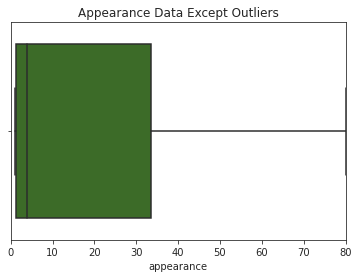

In [192]:
# scatter와 box 동시 표시
# sns.swarmplot(data = jockey_app_rank, x = 'appearance')
sns.boxplot(data = jockey_app_rank, x = 'appearance')
sns.scatterplot(data = jockey_app_rank, x = 'appearance')
plt.xlim([0, 80])
plt.title("Appearance Data Except Outliers")

In [193]:
# upper_boundary 구하기
x = jockey_app_rank['appearance']
q_75, q_25 = np.percentile(x, [75, 25])
iqr = q_75 - q_25
up_boundary = q_75 + 1.5 * iqr
up_boundary

81.875

In [194]:
jockey_app_rank[jockey_app_rank['appearance'] >= up_boundary]['jockey'].count()

29

#### 1. Appearance : IQR을 넘는 이상치 데이터들을 제외

In [195]:
jockey_app_rank_inner = jockey_app_rank[jockey_app_rank['appearance'] <= up_boundary][:]
jockey_app_rank_inner

,jockey,appearance,avg_rank_by_jockey
3,Jomar Garcia,2,5.000000
41,Frankie Pennington,4,4.750000
57,Joel Sone,17,5.882353
74,Julio Correa,68,5.029412
85,Pablo Fragoso,40,6.325000
...,...,...,...
13691,Jose Angel Garcia,1,7.000000
13847,Jose Antonio Gallego,4,7.500000
13866,Sophie Doyle,1,3.000000
14247,Martin Chuan,1,12.000000


corcoef = 0.03427458421381542, p-value = 0.6953111045100181


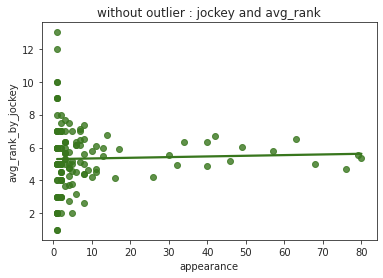

In [196]:
sns.regplot(data = jockey_app_rank_inner, x = 'appearance', y = 'avg_rank_by_jockey', ci = None)
plt.title("without outlier : jockey and avg_rank")
r, p_value = stats.pearsonr(x = jockey_app_rank_inner['appearance'], y = jockey_app_rank_inner['avg_rank_by_jockey'])
print(f"corcoef = {r}, p-value = {p_value}")

corcoef = 0.14844805110940265, p-value = 0.4421747777483574


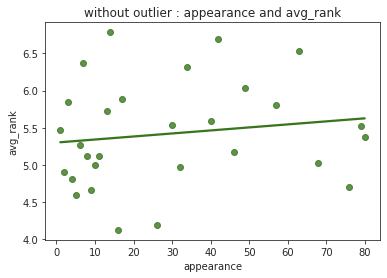

In [197]:
# 이상치를 제외한 플롯
temp_df = jockey_app_rank_inner.groupby('appearance')['avg_rank_by_jockey'].mean().to_frame().reset_index().rename(columns = {'avg_rank_by_jockey' : 'avg_rank'})
sns.regplot(data = temp_df, x = 'appearance', y = 'avg_rank', ci = None)
plt.title('without outlier : appearance and avg_rank')
r, p_value =stats.pearsonr(x = temp_df['appearance'], y = temp_df['avg_rank'])
print(f"corcoef = {r}, p-value = {p_value}")

#### 2. 이상치 데이터를 제거하지 않고 Plot
- 전체 기수는 162명, 경기 출전 수의 `nunique()`값은 58이다.

(-0.16868297382516895, 0.03189222439937974)

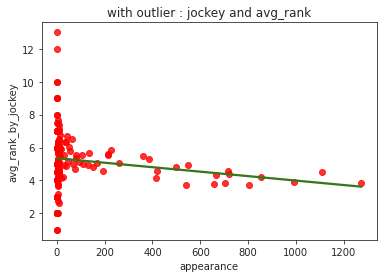

In [198]:
sns.regplot(data = jockey_app_rank,
               x = 'appearance',
               y = 'avg_rank_by_jockey',
               ci = None,
               scatter_kws = {'color' : 'red'})

plt.title("with outlier : jockey and avg_rank")
stats.pearsonr(x = jockey_app_rank['appearance'], y = jockey_app_rank['avg_rank_by_jockey'])

In [199]:
jockey_app_rank['appearance'].nunique()

58

In [200]:
dirt_appear_df = (jockey_df[jockey_df['course_type'] == 'D'].groupby('jockey')['race_id'].count()
                                                                                         .to_frame()
                                                                                         .reset_index()
                                                                                         .rename(columns = {'race_id' : 'dirt_appearance'}))
turf_appear_df = (jockey_df[jockey_df['course_type'].isin(['T', 'I', 'O'])].groupby('jockey')['race_id'].count()
                                                                                                     .to_frame()
                                                                                                     .reset_index()
                                                                                                     .rename(columns = {'race_id' : 'turf_appearance'}))

jockey_df = (jockey_df.merge(dirt_appear_df, how = 'left', on = 'jockey')
                      .merge(turf_appear_df, how = 'left', on = 'jockey'))
jockey_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14842 entries, 0 to 14841
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   race_id             14842 non-null  object  
 1   jockey              14842 non-null  object  
 2   course_type         14842 non-null  object  
 3   dirt_condition      9467 non-null   category
 4   turf_condition      5375 non-null   category
 5   position_at_finish  14842 non-null  int64   
 6   appearance          14842 non-null  int64   
 7   avg_rank_by_jockey  14842 non-null  float64 
 8   dirt_appearance     14795 non-null  float64 
 9   turf_appearance     14680 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 1.0+ MB


In [201]:
jockey_df[['jockey', 'appearance']].drop_duplicates().describe()
# jockey_df[['jockey', 'appearance']].drop_duplicates().plot(kind = 'box')


,appearance
count,162.000000
mean,91.617284
std,224.444328
min,1.000000
25%,1.250000
50%,4.000000
75%,33.500000
max,1274.000000


In [202]:
jockey_df['dirt_appearance'].fillna(0, inplace = True)
jockey_df['turf_appearance'].fillna(0, inplace = True)

jockey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14842 entries, 0 to 14841
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   race_id             14842 non-null  object  
 1   jockey              14842 non-null  object  
 2   course_type         14842 non-null  object  
 3   dirt_condition      9467 non-null   category
 4   turf_condition      5375 non-null   category
 5   position_at_finish  14842 non-null  int64   
 6   appearance          14842 non-null  int64   
 7   avg_rank_by_jockey  14842 non-null  float64 
 8   dirt_appearance     14842 non-null  float64 
 9   turf_appearance     14842 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 1.0+ MB


In [203]:
# 1. 출전 수와 평균 순위
jockey_df['appearance'] = jockey_df.groupby('jockey')['race_id'].transform('nunique')
app_rank = (jockey_df.groupby('appearance')['position_at_finish'].mean()
                                                                 .to_frame()
                                                                 .reset_index()
                                                                 .rename(columns = {'position_at_finish' : 'avg_rank'}))

# 2. Dirt 출전 수와 평균 순위
dirt_app_rank = (jockey_df[jockey_df['course_type'] == 'D'].groupby('dirt_appearance')['position_at_finish']
                                                           .mean()
                                                           .to_frame()
                                                           .reset_index()
                                                           .rename(columns = {'position_at_finish' : 'dirt_avg_rank'}))

turf_app_rank = (jockey_df[jockey_df['course_type'].isin(['T', 'I', 'O'])].groupby('turf_appearance')['position_at_finish']
                                                                           .mean()
                                                                           .to_frame()
                                                                           .reset_index()
                                                                           .rename(columns = {'position_at_finish' : 'turf_avg_rank'}))

상관계수 : -0.631658005069876, p-value : 1.0554257650012832e-07


Text(0.5, 1.0, 'Total Appearance and Average Rank')

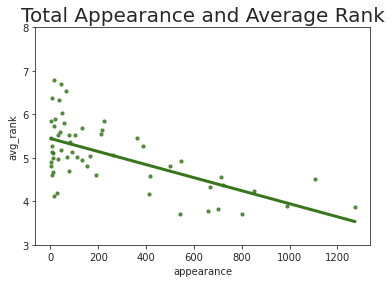

In [204]:
def get_regplot(df, col1_name, col2_name):
    sns.regplot(data = df,
                x = col1_name,
                y = col2_name,
                ci = None,
                line_kws = {
#                             'color' : 'grey',
                            'lw' : 3
                },
                scatter_kws = {'s' : 10,
#                               'color' : 'grey'
                              })
    
    plt.ylim([3, 8])

def get_pearsonr(col1, col2):
    corrcoef, p_value = stats.pearsonr(x = col1,
                                       y = col2)
    print(f"상관계수 : {corrcoef}, p-value : {p_value}")
    
get_regplot(app_rank, 'appearance', 'avg_rank')
get_pearsonr(app_rank['appearance'], app_rank['avg_rank'])
plt.title("Total Appearance and Average Rank", fontsize = 20)

상관계수 : -0.6305955921051908, p-value : 5.43089806006367e-07


Text(0.5, 1.0, 'Dirt : Appearance and Average Rank')

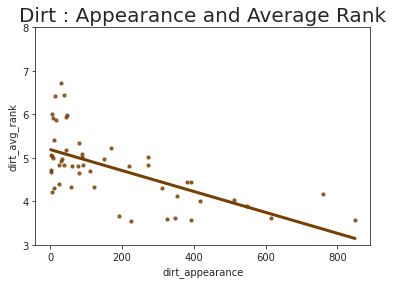

In [206]:
sns.set_palette(sns.color_palette(dirt_colors))
get_regplot(dirt_app_rank, 'dirt_appearance', 'dirt_avg_rank')
get_pearsonr(dirt_app_rank['dirt_appearance'], dirt_app_rank['dirt_avg_rank'])
plt.title("Dirt : Appearance and Average Rank", fontsize = 20)

상관계수 : -0.5625490140785173, p-value : 0.000105486902442249


Text(0.5, 1.0, 'Turf : Appearance and Average Rank')

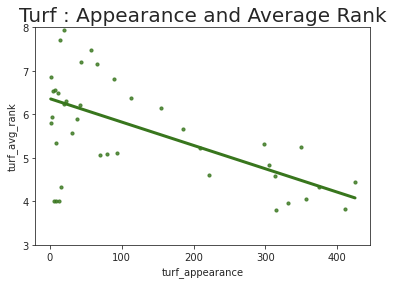

In [207]:
sns.set_palette(sns.color_palette(turf_colors))
get_regplot(turf_app_rank, 'turf_appearance', 'turf_avg_rank')
get_pearsonr(turf_app_rank['turf_appearance'], turf_app_rank['turf_avg_rank'])
plt.title("Turf : Appearance and Average Rank", fontsize = 20)

### 2. Turf의 종류(Inner, Outer, Turf) 간 유의미한 차이가 있는가?
- 물론 달리는 위치가 다를 것이므로 전체적인 구분은 의미가 있을 것임 : 회전 반경이 넓냐 좁냐도 경주에 영향을 미칠 것이기 때문임

In [211]:
turf_race_df = race_df[race_df['course_type'].isin(['O', 'T', 'I'])][:]
turf_race_df.head(2)

,race_id,track_id,race_date,race_number,distance_id,course_type,run_up_distance,race_type,distance_feet,dirt_condition,turf_condition,month,season
392,AQU_2019-04-05_6,AQU,2019-04-05,6,800,O,64,CLM,5280,NaN,FM,4,spring
395,AQU_2019-04-05_9,AQU,2019-04-05,9,800,T,63,MSW,5280,NaN,FM,4,spring


In [212]:
turf_race_df[['track_id', 'course_type']]

,track_id,course_type
392,AQU,O
395,AQU,T
400,AQU,O
409,AQU,O
411,AQU,T
...,...,...
1980,SAR,T
1983,SAR,T
1985,SAR,I
1988,SAR,I


### 경기장 보기
- [참고](https://www.kaggle.com/code/iamleonie/big-data-derby-step-by-step-analysis#Missing-Data) 
    - 경,위도 데이터를 보고 경기장을 그릴 수 있다는 생각은 못했다. 아이디어만 보고 구현은 직접 해본다

In [213]:
track = start_df['track_id'].unique()
total_df = race_df.merge(track_df, on = ['track_id', 'race_date', 'race_number'])

In [214]:
track_lst = race_df['track_id'].unique()
track_lst

array(['AQU', 'BEL', 'SAR'], dtype=object)

In [215]:
race_df['course_type'].unique()

array(['D', 'O', 'T', 'I'], dtype=object)

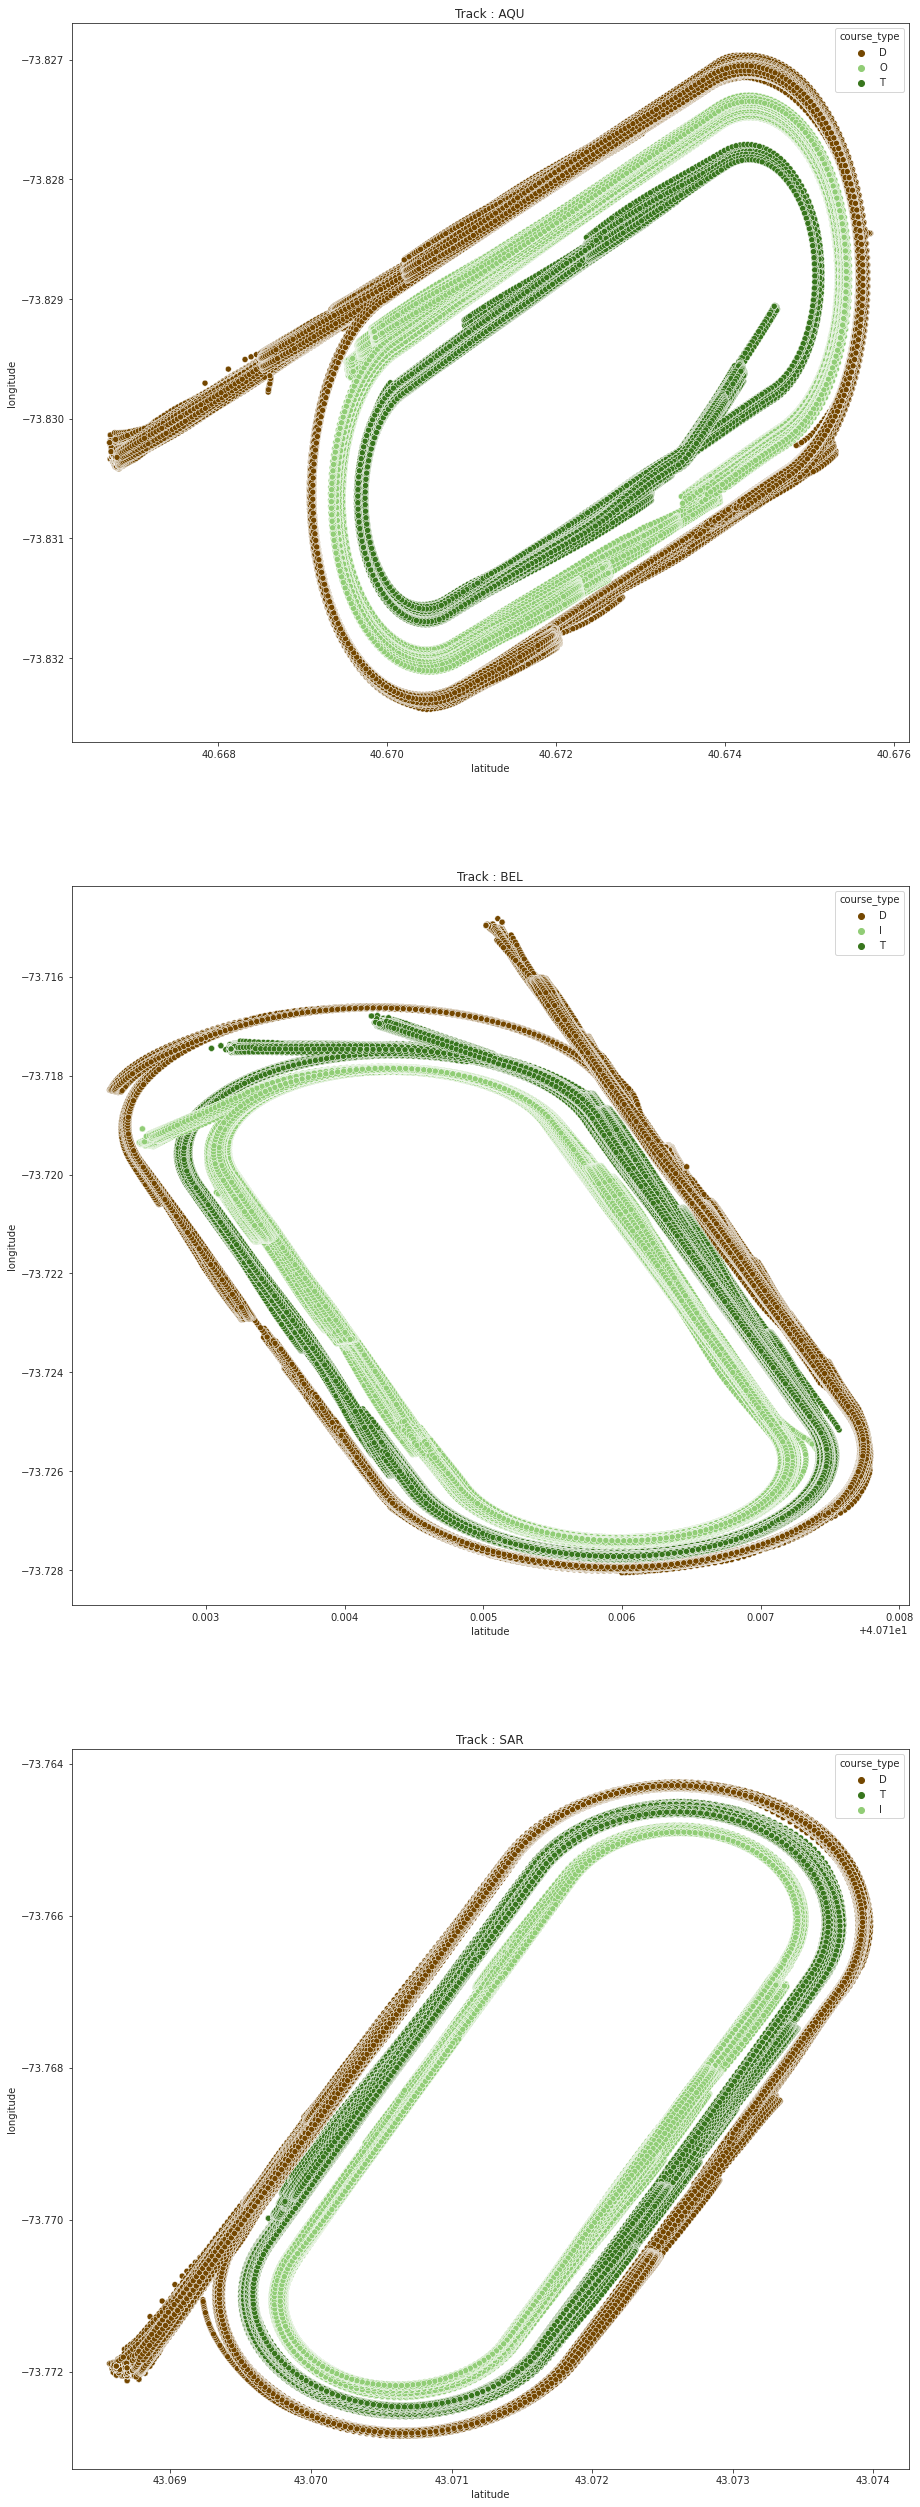

In [323]:
# 경기장을 나타내는 점들이기 때문에 사실 하려는 거에 비해 점이 너무 많긴 함
# 이를 줄여줘도 됨

fig, ax = plt.subplots(3, 1, figsize = (15, 45))
track_palette = {'D' : '#744700',
        'T' : '#38761d',
        'I' : '#91cd76',
        'O' : '#91cd76', 
        'M' : '#d9ead3'}

for i, v in enumerate(track_lst):
    temp_df = total_df[(total_df['track_id'] == v) &(total_df['trakus_index'].isin(list(range(0, 200))))][['course_type', 'latitude', 'longitude']]

    sns.scatterplot(data = temp_df,
                       x = 'latitude',
                       y = 'longitude',
                       hue = 'course_type',
                        ax = ax[i],
                   palette = track_palette)
    
    ax[i].set_title(f'Track : {v}')

- trakus가 뭔지 (나중에) 보자

### 경기 분석
- 가장 규모가 큰 `Stakes` 레이스만 분석해봄
- 경주 거리는 `3630 ~ 10560`까지 있음 (단위 : 피트)
- `run_up_distance` : `9 ~ 246` 


In [249]:
race_track = track_df.merge(race_df, on = ['track_id', 'race_date', 'race_number'])
race_track.insert(0, 'race_id', race_track.pop('race_id'))
# race_track.drop(['track_id', 'race_date', 'race_number'], axis = 1, inplace = True)
race_track.head(2)

,race_id,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,run_up_distance,race_type,distance_feet,dirt_condition,turf_condition,month,season
0,AQU_2019-01-01_9,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,48,CLM,3960,GD,NaN,1,winter
1,AQU_2019-01-01_9,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,48,CLM,3960,GD,NaN,1,winter


In [250]:
stakes = race_track[race_track['race_type'] == 'STK'][:] # 경기 거리는 3630 ~ 10560까지 있다
stk_dirt = stakes[stakes['course_type'] == 'D'][:].drop('turf_condition', axis = 1)
stk_turf = stakes[stakes['course_type'].isin(['T', 'I', 'O'])][:].drop('dirt_condition', axis = 1)

In [313]:
stakes['run_up_distance'].describe()

count    683284.000000
mean         75.133353
std          39.163384
min           9.000000
25%          48.000000
50%          72.000000
75%          86.000000
max         246.000000
Name: run_up_distance, dtype: float64

1. run_up_distance
- 도대체 저게 뭐인데 들어가있는가

In [273]:
test_df['track_id'].unique()

array(['SAR', 'AQU', 'BEL'], dtype=object)

In [320]:
trakus_idx = 200
test_df = stk_dirt[stk_dirt['trakus_index'].isin(list(range(0, trakus_idx)))][['race_id', 'track_id', 'program_number', 'trakus_index', 'latitude', 'longitude', 'run_up_distance']]
test_SAR_df = test_df[test_df['track_id'] == 'SAR'][:]
test_AQU_df = test_df[test_df['track_id'] == 'AQU'][:]
test_BEL_df = test_df[test_df['track_id'] == 'BEL'][:]

In [321]:
test_SAR_df['race_id'].nunique() # SAR 39경기
test_AQU_df['race_id'].nunique() # AQU 59경기
test_BEL_df['race_id'].nunique() # BEL 49경기

49

<Figure size 1440x1080 with 0 Axes>

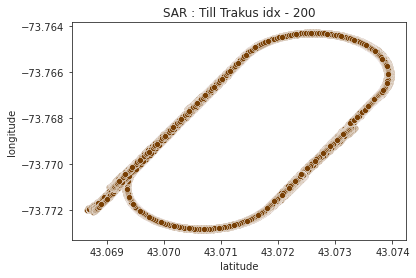

<Figure size 1440x1080 with 0 Axes>

In [322]:
sns.set_palette(sns.color_palette(dirt_colors))
sns.scatterplot(data = test_SAR_df,
               x = 'latitude',
               y = 'longitude')
plt.title(f'SAR : Till Trakus idx - {trakus_idx}')
plt.figure(figsize = (20, 15))